In [17]:
import torch
from torch import nn
import pybuda
from PIL import Image
import torchvision
from torch.utils.data import Dataset, DataLoader

In [18]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("dyllanesl/ASL_Classifier")
model = AutoModelForImageClassification.from_pretrained("dyllanesl/ASL_Classifier")

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [19]:
tt0 = pybuda.TTDevice(
    name="tt_device_0",  # here we can give our device any name we wish, for tracking purposes
)

In [20]:
# Create module
pybuda_module = pybuda.PyTorchModule(
    name = "asl_model",  # give the module a name, this will be used for tracking purposes
    module=model  # specify the model that is being targeted for compilation
)

# Place module on device
tt0.place_module(module=pybuda_module)

In [21]:
from datasets import load_dataset

# Load the dataset from Hugging Face
dataset = load_dataset('raulit04/ASL_Dataset1')['train']

Using custom data configuration raulit04--ASL_Dataset1-d033ce9363c88848
Reusing dataset parquet (/home/user/.cache/huggingface/datasets/raulit04___parquet/raulit04--ASL_Dataset1-d033ce9363c88848/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)
100%|██████████| 1/1 [00:00<00:00, 435.23it/s]


In [22]:
# Create a mapping from labels to IDs
label_list = dataset.unique('label')

label_to_id = {label: idx for idx, label in enumerate(label_list)}
id_to_label = {idx: label for idx, label in enumerate(label_to_id)}

In [33]:
# Set PyBUDA configuration parameters
# STEP 1 : Set PyBuda configuration parameters
import os
# STEP 1 : Set PyBuda configuration parameters
compiler_cfg = pybuda.config._get_global_compiler_config()
compiler_cfg.balancer_policy = "Ribbon"
compiler_cfg.default_df_override = pybuda.DataFormat.Float32


In [11]:
def setup_image(image: Image):
    image.convert("RGB")
    processed_tensor = processor(images=image, return_tensors='pt')
    return processed_tensor['pixel_values']

In [31]:
def get_prediction_given_tensor(input_tensor):
    # tt0.push_to_inputs((input_tensor,))
    output = pybuda_module.run(input_tensor)  # executes compilation (if first time) + runtime
    # output = output_q.get()  # get last value from output queue
    pred = output.logits.argmax(-1).item()
    return id_to_label[pred]

image: 


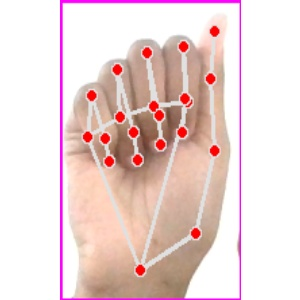

2024-08-02 22:24:16.340 | INFO     | Backend         - initialize_child_process called on pid 229072


/usr/local/lib/python3.8/dist-packages/transformers/modeling_utils.py:4481: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/models/vit/modeling_vit.py:164: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_channels != self.num_channels:
/usr/local/lib/python3.8/dist-packages/transformers/models/vit/modeling_vit.py:170: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if height != sel

2024-08-02 22:24:39.872 | INFO     | Backend         - initialize_child_process called on pid 320697
2024-08-02 22:24:39.875 | INFO     | Backend         - initialize_child_process called on pid 320688


KeyboardInterrupt: 

In [34]:
dataset_length = len(dataset['image'])
correct = 0
for i, (image, label) in enumerate(zip(dataset['image'], dataset['label'])):
    if i == 0:
        print('image: ')
        display(image)
    readied_tensor = setup_image(image)
    guessed_label = get_prediction_given_tensor(readied_tensor)
    
    if i < 5:
        print('actual label: ', label, ' guessed label: ', guessed_label)
    if i ==5:
        print("you get the deal. I'll just print out the accuracy")
    correct += 1 if label == guessed_label else 0

print('accuracy: ', correct/dataset_length)

In [38]:
pybuda.shutdown()

2024-08-02 22:43:43.591 | DEBUG    | pybuda.run.impl:_shutdown:1269 - PyBuda shutdown


In [ ]:
import pybuda
import torch


# Sample PyTorch module
class PyTorchTestModule(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.weights1 = torch.nn.Parameter(torch.rand(32, 32), requires_grad=True)
        self.weights2 = torch.nn.Parameter(torch.rand(32, 32), requires_grad=True)
    def forward(self, act1, act2):
        m1 = torch.matmul(act1, self.weights1)
        m2 = torch.matmul(act2, self.weights2)
        return m1 + m2, m1


def test_module_direct_pytorch():
    input1 = torch.rand(4, 32, 32)
    input2 = torch.rand(4, 32, 32)
    # Run single inference pass on a PyTorch module, using a wrapper to convert to PyBuda first
    output = pybuda.PyTorchModule("direct_pt", PyTorchTestModule()).run(input1, input2)
    print(output)
    print("PyBuda installation was a success!")


if __name__ == "__main__":
    test_module_direct_pytorch()